In [1]:
import numpy as np
import pandas as pd
import os
import random as rd
import datetime as dt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from pandas.plotting import autocorrelation_plot


import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

We are going to be looking at a Time Series Datasets. I have done a lot of time series problem while being an MBA candidate and Data Analyst at Tarleton. While taking Econometrics, I had a lot of Time Series Analysis to do as class projects. One difficulty I had, was to know when to use the ARIMA model (Auto-Regression Integrated Moving-Average). After a while doing it, I started to get the hang of it. Now I am going to work more of these types of projects

What is ARIMA?

ARIMA is a model which is used for predicting future trends on a time series data. It is model that form of regression analysis.

AR (Autoregression) : Model that shows a changing variable that regresses on its own lagged/prior values.

I (Integrated) : Differencing of raw observations to allow for the time series to become stationary.

MA (Moving average) : Dependency between an observation and a residual error from a moving average model

For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used.

p: the number of lag observations in the model; also known as the lag order.

d: the number of times that the raw observations are differenced; also known as the degree of differencing.

q: the size of the moving average window; also known as the order of the moving average.

In [2]:
itemcateg = pd.read_csv("C:/Users/Delmafia91/Downloads/item_categories.csv")
shop = pd.read_csv("C:/Users/Delmafia91/Downloads/shops.csv")
test = pd.read_csv("C:/Users/Delmafia91/Downloads/test.csv")
sales = pd.read_csv("C:/Users/Delmafia91/Downloads/sales_train.csv")
items = pd.read_csv("C:/Users/Delmafia91/Downloads/items.csv")
sub = pd.read_csv("C:/Users/Delmafia91/Downloads/sample_submission.csv")

In [3]:
sada = sales.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
date              1048575 non-null object
date_block_num    1048575 non-null int64
shop_id           1048575 non-null int64
item_id           1048575 non-null int64
item_price        1048575 non-null float64
item_cnt_day      1048575 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 48.0+ MB
None


In [4]:
# Calculated to monthly level by the required metrics

salemonth = sales.groupby(["date_block_num", "shop_id",
            "item_id"])["date","item_price", 
            "item_cnt_day"].agg({"date": ['min',
            "max"], "item_price":"mean", "item_cnt_day":
                                "sum"})

#aggregate by date block(month), shop_id, item_id 
#(This is a SQL command) 
#select the column date, item price, and item cnt(sales)
#min and max on the date
#average item price
#sum the sales

In [5]:
salemonth.head()

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013      221.0            6
                       33       03.01.2013  28.01.2013      347.0            3
                       35       31.01.2013  31.01.2013      247.0            1
                       43       31.01.2013  31.01.2013      221.0            1
                       51       13.01.2013  31.01.2013      128.5            2

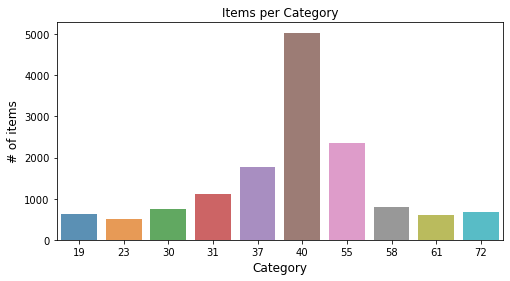

In [6]:
# Number of items per category
i = items.groupby(['item_category_id']).count()
i = i.sort_values(by='item_id', ascending = False)
i = i.iloc[0:10].reset_index()
i

# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(i.item_category_id, i.item_id, alpha = 0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize = 12)
plt.xlabel('Category', fontsize = 12)
plt.show()

# Univeriate series

The objective is to predict sales for the next month. Sales over time of each store-item is a time-series in itself. How do we forecast a univeriate series?

We are going to compute the total sales per month and that result.

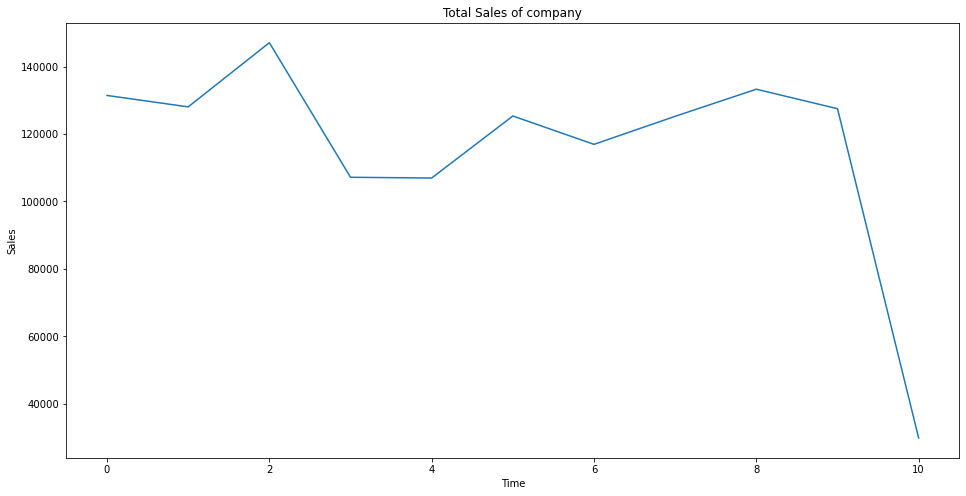

In [7]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize =(16, 8))
plt.title('Total Sales of company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

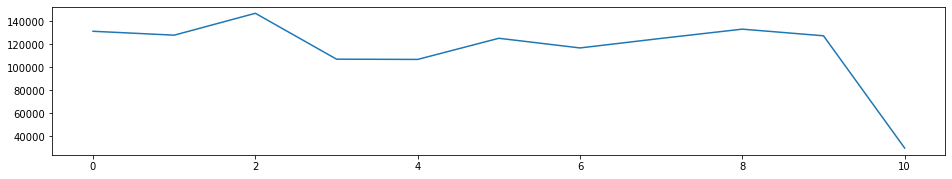

In [8]:
plt.figure(figsize = (16, 6))
ax1 = plt.subplot2grid((2,1), (0,0))
#ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
plt.plot(ts.rolling(1).mean())

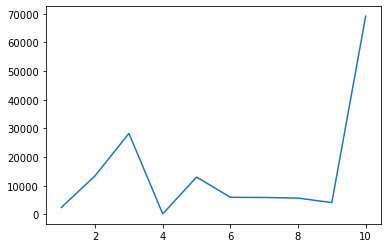

In [9]:
plt.figure()
plt.plot(ts.rolling(2).std())

Let us look for trend, seasonality and residuals

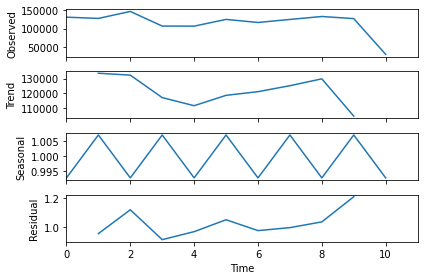

In [14]:
res = sm.tsa.seasonal_decompose(ts.values, 
            freq = 2, model = "multiplicative")
fig = res.plot()

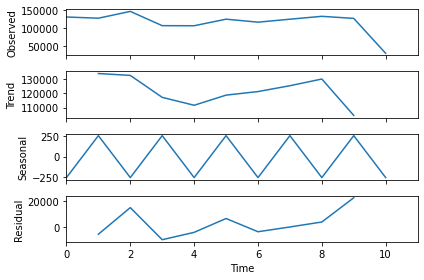

In [15]:
res = sm.tsa.seasonal_decompose(ts.values, freq = 2, 
                               model = "additive")
fig = res.plot()

When I took Economotrics, we talked about data being stationary. What does this mean?

When a data is stationary, it simply means that there is no increase or decrease over time. It could be the mean, variance, or standard deviation. For a data to be stationary, the plot of the data should be uniform, looking like an horizontal line.

In [25]:
# Stationary tests
def station(timeseries):
    print('Results of Dickey-Fuller Test:')
    DFtest = adfuller(timeseries, autolag = 'AIC')
    DFoutput = pd.Series(DFtest[0:4], index = ['Test Statistic', 'p-value','#Lags Used', 'Number of Observations Used'])
    for key, value in DFtest[4].items():
        DFoutput['Critical Value (%s)'%key] = value
    print(DFoutput)
    
station(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.248547
p-value                         0.652371
#Lags Used                      0.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64
